In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import joblib

Chargement des données...
Préparation des caractéristiques...
Création du pipeline...
Optimisation des hyperparamètres...
Meilleurs paramètres: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Évaluation du modèle...

Métriques d'évaluation:
MSE: 1631040.3318
RMSE: 1277.1219
MAE: 498.1300
R2: 0.9540
Génération des visualisations...


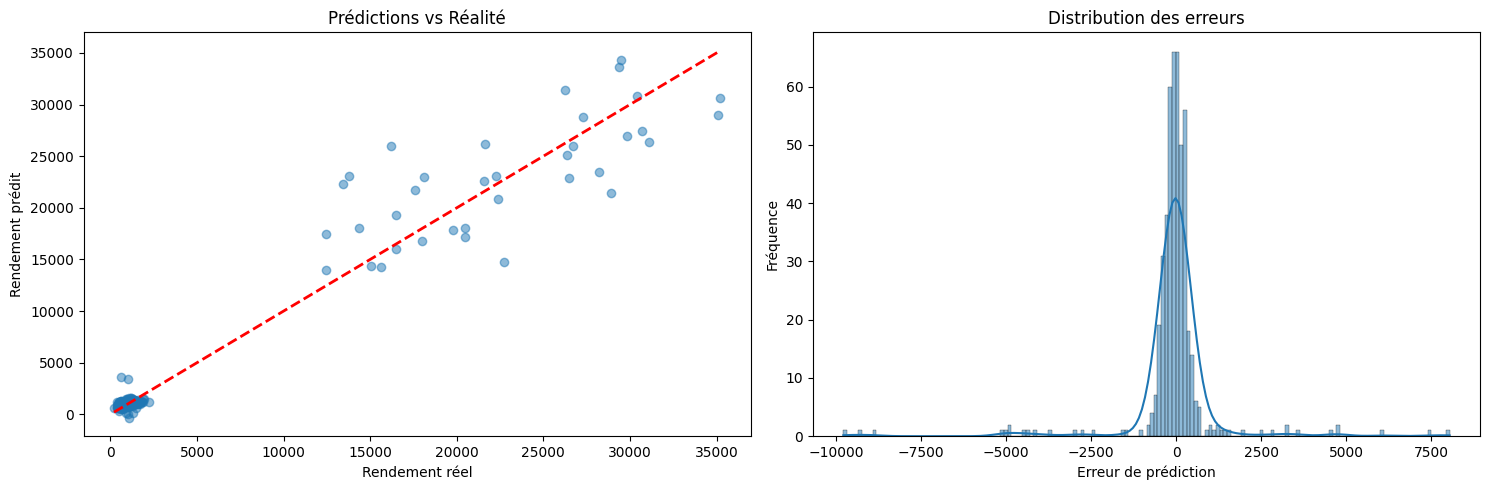

L'importance des caractéristiques n'est pas disponible
Modèle sauvegardé sous model.joblib


In [1]:
class AgriPredictSfaxModel:
    def __init__(self, data_path='/home/haghob/AgriPredictSfax/'):
        """Initialise le modèle avec le chemin vers les données."""
        self.data_path = data_path
        self.model = None
        self.feature_importance = None
        
    def load_data(self):
        """Charge et combine les données des différentes sources."""
        try:
            self.crop_data = pd.read_csv(f'{self.data_path}crop_data_sfax.csv', parse_dates=['date'])
            self.soil_data = pd.read_csv(f'{self.data_path}soil_data_sfax.csv')
            self.climate_data = pd.read_csv(f'{self.data_path}climate_data_sfax.csv', parse_dates=['date'])
            
            return self._combine_data()
        except Exception as e:
            print(f"Erreur lors du chargement des données: {str(e)}")
            raise
    
    def _combine_data(self):
        """Combine et prépare les données avec feature engineering avancé."""
        combined_data = self.crop_data.merge(self.soil_data, on='field_id').merge(
            self.climate_data, on='date')
        
        #feature Engineering avancé
        combined_data['season'] = pd.cut(combined_data['date'].dt.month,
                                       bins=[0, 3, 6, 9, 12],
                                       labels=['Winter', 'Spring', 'Summer', 'Autumn'])
        
        combined_data['month'] = combined_data['date'].dt.month
        combined_data['day_of_year'] = combined_data['date'].dt.dayofyear
        
        combined_data['temp_humidity_interaction'] = (
            combined_data['temperature_avg'] * combined_data['humidity'])
        combined_data['drought_index'] = (
            combined_data['temperature_max'] / (combined_data['precipitation'] + 1))
        
        combined_data['npk_ratio'] = (
            combined_data['nitrogen'] + combined_data['phosphorus'] + combined_data['potassium']) / 3
        
        return combined_data
    
    def prepare_features(self, data):
        """Prépare les caractéristiques pour l'entraînement."""
        self.numeric_features = [
            'temperature_avg', 'temperature_min', 'temperature_max', 'precipitation',
            'humidity', 'pH', 'nitrogen', 'phosphorus', 'potassium', 'calcium',
            'profondeur_sol', 'matiere_organique', 'temp_humidity_interaction',
            'drought_index', 'npk_ratio', 'day_of_year'
        ]
        
        self.categorical_features = [
            'crop_type', 'irrigation', 'soil_type', 'season',
            'fertilizer_used'
        ]
        
        return data[self.numeric_features + self.categorical_features], data['yield']
    
    def create_pipeline(self):
        """Crée un pipeline avec preprocessing et modèle."""
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ])

        #modification ici pour la compatibilité avec différentes versions de scikit-learn
        try:
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            #pour les versions plus anciennes de scikit-learn
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])

        self.model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ])

        return self.model
    
    def optimize_hyperparameters(self, X_train, y_train):
        """Optimise les hyperparamètres du modèle."""
        param_grid = {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.01, 0.1],
            'regressor__max_depth': [3, 5]
        }
        
        grid_search = GridSearchCV(
            self.model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        print("Meilleurs paramètres:", grid_search.best_params_)
        return grid_search.best_estimator_
    
    def evaluate_model(self, X_test, y_test, y_pred):
        """Évalue le modèle avec plusieurs métriques."""
        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }
        
        print("\nMétriques d'évaluation:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
            
        return metrics
    
    def plot_results(self, y_test, y_pred):
        """Génère des visualisations des résultats."""
        plt.figure(figsize=(15, 5))
        
        #prédictions vs Réalité
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Rendement réel')
        plt.ylabel('Rendement prédit')
        plt.title('Prédictions vs Réalité')
        
        plt.subplot(1, 2, 2)
        errors = y_test - y_pred
        sns.histplot(errors, kde=True)
        plt.xlabel('Erreur de prédiction')
        plt.ylabel('Fréquence')
        plt.title('Distribution des erreurs')
        
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=15):
        """Affiche l'importance des caractéristiques."""
        if hasattr(self.model, 'feature_names_'):
            feature_names = self.model.feature_names_
            feature_importance = self.model.named_steps['regressor'].feature_importances_
            
            plt.figure(figsize=(10, 6))
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True)
            
            plt.barh(range(min(top_n, len(importance_df))), 
                    importance_df['importance'][-top_n:])
            plt.yticks(range(min(top_n, len(importance_df))), 
                      importance_df['feature'][-top_n:])
            plt.xlabel('Importance')
            plt.title(f'Top {top_n} caractéristiques les plus importantes')
            plt.tight_layout()
            plt.show()
        else:
            print("L'importance des caractéristiques n'est pas disponible")

    def save_model(self, filename='model.joblib'):
        """Sauvegarde le modèle entraîné."""
        if self.model is not None:
            joblib.dump(self.model, f'{self.data_path}{filename}')
            print(f"Modèle sauvegardé sous {filename}")
    
    def load_model(self, filename='model.joblib'):
        """Charge un modèle précédemment sauvegardé."""
        self.model = joblib.load(f'{self.data_path}{filename}')
        print("Modèle chargé avec succès")

def main():
    aps_model = AgriPredictSfaxModel()
    
    try:
        print("Chargement des données...")
        combined_data = aps_model.load_data()
        
        print("Préparation des caractéristiques...")
        X, y = aps_model.prepare_features(combined_data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        print("Création du pipeline...")
        aps_model.create_pipeline()
        
        print("Optimisation des hyperparamètres...")
        best_model = aps_model.optimize_hyperparameters(X_train, y_train)
        aps_model.model = best_model
        
        print("Évaluation du modèle...")
        y_pred = aps_model.model.predict(X_test)
        metrics = aps_model.evaluate_model(X_test, y_test, y_pred)
        
        print("Génération des visualisations...")
        aps_model.plot_results(y_test, y_pred)
        aps_model.plot_feature_importance()
        
        aps_model.save_model()
        
    except Exception as e:
        print(f"Une erreur est survenue: {str(e)}")

if __name__ == "__main__":
    main()